In [8]:
# Importo linrerias necesarias
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import det_curve
from sklearn.metrics import accuracy_score

In [9]:
# Preparo los datos
data = pd.read_csv('../archivo_modificado_final.csv')

# Definir el umbral de no nulos
umbral = 0.90  

# Calcular el porcentaje de valores no nulos por columna
porcentaje_no_nulos = data.notnull().mean()

# Filtrar las columnas que cumplen con el umbral
columnas_filtradas = porcentaje_no_nulos[porcentaje_no_nulos > umbral].index

# Crear un nuevo DataFrame con solo esas columnas
df_filtrado = data[columnas_filtradas]

# Mostrar el resultado
print(df_filtrado.shape)

(7440, 63)


In [10]:
# Definir el umbral de no nulos
umbral_filas = 0.30  

# Calcular el número mínimo de valores no nulos requeridos por fila
min_no_nulos = int(umbral_filas * df_filtrado.shape[1])

# Eliminar las filas que no cumplen con el umbral
df_filtrado_filas = df_filtrado.dropna(thresh=min_no_nulos)

# Mostrar el resultado
print(df_filtrado_filas.shape)

(7440, 63)


In [11]:
# Saco la mediana de cada columna y la relleno en los valores nulos
df_filtrado_filas2 = df_filtrado_filas.drop(columns=['usuario'])
df_filtrado_filas2 = df_filtrado_filas2.fillna(df_filtrado_filas2.mean())
df_filtrado_filas2 = df_filtrado_filas2.round(2)

# Reemplazar los valores inf por nan
df_filtrado_filas2 = df_filtrado_filas2.replace([np.inf, -np.inf], np.nan)
# Reeemplazar los valores nan por la media de la columna
datos_final = df_filtrado_filas2.fillna(df_filtrado_filas2.mean())

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import os

# Crear directorios para guardar resultados
os.makedirs('ANN_Ses1Ses2/curvas_det_digitos', exist_ok=True)
os.makedirs('ANN_Ses1Ses2/curvas_det_usuarios', exist_ok=True)


# Separar características y etiquetas
X = datos_final.drop(columns=['usuario_num', 'muestra', 'sesion', 'digito']).values
y = datos_final['digito'].values
usuarios = datos_final['usuario_num'].values
sesiones = datos_final['sesion'].values

# Normalizar características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Codificar etiquetas (si no están ya como números)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Obtener la lista de usuarios únicos
usuarios_unicos = np.unique(datos_final["usuario_num"])

# Crear máscaras para separar datos
# Conjunto de entrenamiento: usuarios seleccionados, da igual la sesion
mascara_train = datos_final["sesion"] == 1
X_train = X[mascara_train]
y_train = y[mascara_train]

# Conjunto de test: el resto (usuarios no seleccionados)
mascara_test = ~mascara_train
X_test = X[mascara_test]
y_test = y[mascara_test]
usuarios_test = usuarios[mascara_test]

# Construir el modelo ANN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # 10 clases para los dígitos 0-9
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo en conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión global en test: {test_acc * 100:.2f}%')

# Obtener predicciones del modelo
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)

# ----- 1. Matriz de confusión general y accuracy por dígito -----
print("\n----- MATRIZ DE CONFUSIÓN GENERAL -----")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicción')
plt.ylabel('Valor Real')

# Añadir valores en cada celda
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig('ANN_Ses1Ses2/matriz_confusion_general.png')
plt.close()

# Accuracy por dígito
print("\n----- ACCURACY POR DÍGITO -----")
accuracies_digito = []
for i in range(10):
    # Filtrar los valores para el dígito i
    indices_digito = (y_test == i)
    if np.sum(indices_digito) > 0:
        acc_digito = accuracy_score(y_test[indices_digito], y_pred[indices_digito])
        accuracies_digito.append(acc_digito)
        print(f'Accuracy para el dígito {i}: {acc_digito * 100:.2f}%')
    else:
        print(f'No hay muestras para el dígito {i}')
        accuracies_digito.append(0)

# Graficar accuracy por dígito
plt.figure(figsize=(10, 6))
plt.bar(range(10), [acc * 100 for acc in accuracies_digito])
plt.xlabel('Dígito')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy por Dígito')
plt.xticks(range(10))
plt.grid(True, axis='y')
plt.savefig('ANN_Ses1Ses2/accuracy_por_digito.png')
plt.close()

# ----- 2. Accuracy por usuario -----
print("\n----- ACCURACY POR USUARIO -----")
# Crear DataFrame para resultados por usuario
resultados_usuario = pd.DataFrame({
    'usuario_num': usuarios_test,
    'real': y_test,
    'predicho': y_pred,
    'correcto': y_test == y_pred
})

# Calcular accuracy por usuario
accuracies_usuario = resultados_usuario.groupby('usuario_num')['correcto'].mean()
total_muestras = resultados_usuario.groupby('usuario_num')['correcto'].count()

# Crear DataFrame con resultados
df_accuracies = pd.DataFrame({
    'usuario_num': accuracies_usuario.index,
    'accuracy': accuracies_usuario.values,
    'total_muestras': total_muestras.values
})
df_accuracies['accuracy_porcentaje'] = df_accuracies['accuracy'] * 100

# Ordenar por accuracy (ascendente)
df_accuracies = df_accuracies.sort_values('accuracy')

# Mostrar usuarios con peor y mejor accuracy
print("\nUsuarios con peor accuracy:")
print(df_accuracies.head(5))
print("\nUsuarios con mejor accuracy:")
print(df_accuracies.tail(5))

# Guardar resultados
df_accuracies.to_csv('ANN_Ses1Ses2/accuracy_por_usuario.csv', index=False)

# ----- 3. Función para calcular EER y curvas DET -----
def calculate_eer(y_true, y_score):
    """Versión robusta del cálculo de EER que maneja casos extremos"""
    # Verificar variabilidad en los puntajes
    if len(np.unique(y_score)) <= 1:
        return None, None, None, None  # No se puede calcular EER
    
    # Verificar variabilidad en las etiquetas
    if len(np.unique(y_true)) <= 1:
        return None, None, None, None  # No se puede calcular EER
    
    # Añadir pequeña variación a puntajes iguales para evitar problemas numéricos
    if len(np.unique(y_score)) < len(y_score):
        y_score = y_score + np.random.normal(0, 1e-10, len(y_score))
    
    try:
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        fnr = 1 - tpr
        
        # Verificar si hay suficientes puntos para interpolación
        if len(fpr) <= 2:
            return None, None, fpr, fnr
        
        # Usar método más robusto para encontrar el EER
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr, kind='linear', bounds_error=False, 
                                              fill_value=(0,1))(x), 0., 1., xtol=1e-8)
        threshold = interp1d(fpr, thresholds, bounds_error=False)(eer)
        
        return eer, threshold, fpr, fnr
    except Exception as e:
        print(f"Error en cálculo robusto de EER: {e}")
        return None, None, None, None

def plot_det_curve(fpr, fnr, eer=None, label=None, title=None, filename=None):
    """Grafica la curva DET"""
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, fnr, 'b-', linewidth=2, label=label if label else 'Curva DET')
    plt.plot([0, 1], [0, 1], 'k--', label='EER line')
    
    # Marcar el punto EER si está disponible
    if eer is not None:
        idx_eer = np.argmin(np.abs(fpr - (1-fnr)))
        plt.plot(fpr[idx_eer], fnr[idx_eer], 'ro', markersize=8, label=f'EER = {eer:.4f}')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('False Negative Rate (FNR)')
    plt.title(title if title else 'Curva DET')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    if filename:
        plt.savefig(f"ANN_Ses1Ses2/{filename}")
        plt.close()
    else:
        plt.show()

# ----- 4. Análisis DET y EER por dígito -----
print("\n----- ANÁLISIS DET Y EER POR DÍGITO -----")
eers_digito = []
digitos = []

# One-vs-Rest para cada dígito
for digito in range(10):
    # Preparar etiquetas binarias (1 para el dígito actual, 0 para los demás)
    y_true_bin = (y_test == digito).astype(int)
    # Obtener probabilidades para el dígito actual
    y_score = y_probs[:, digito]
    
    try:
        # Calcular EER
        eer, threshold, fpr, fnr = calculate_eer(y_true_bin, y_score)
        eers_digito.append(eer)
        digitos.append(digito)
        
        print(f"Dígito {digito}: EER = {eer:.4f}, Umbral = {threshold:.4f}")
        
        # Guardar curva DET para este dígito
        plot_det_curve(
            fpr, fnr, eer=eer,
            label=f"Dígito {digito} (EER={eer:.4f})",
            title=f"Curva DET para Dígito {digito}",
            filename=f"curvas_det_digitos/det_digito_{digito}.png"
        )
    except Exception as e:
        print(f"Error al calcular EER para Dígito {digito}: {e}")

# Ordenar EER por dígito
df_eer_digito = pd.DataFrame({
    'digito': digitos,
    'eer': eers_digito
})
df_eer_digito = df_eer_digito.sort_values('eer')
df_eer_digito.to_csv('ANN_Ses1Ses2/eer_por_digito_ordenado.csv', index=False)

# Graficar EER por dígito (ordenado)
plt.figure(figsize=(10, 6))
plt.bar(df_eer_digito['digito'], df_eer_digito['eer'])
plt.xlabel('Dígito')
plt.ylabel('Equal Error Rate (EER)')
plt.title('EER por Dígito (ordenado de menor a mayor)')
plt.xticks(range(10))
plt.grid(True, axis='y')
plt.savefig('ANN_Ses1Ses2/eer_por_digito_ordenado.png')
plt.close()

# ----- 5. Análisis DET y EER por usuario -----
print("\n----- ANÁLISIS DET Y EER POR USUARIO -----")
eers_usuario = []
usuarios_analizados = []

# Obtener usuarios únicos en test
usuarios_unicos_test = np.unique(usuarios_test)

for usuario in usuarios_unicos_test:
    # Filtrar datos para este usuario
    indices_usuario = resultados_usuario['usuario_num'] == usuario
    
    # Verificar si hay suficientes muestras
    if sum(indices_usuario) < 20:
        print(f"Usuario {usuario}: insuficientes muestras ({sum(indices_usuario)}). Omitido.")
        continue
    
    # Datos específicos del usuario
    y_true_usuario = resultados_usuario.loc[indices_usuario, 'real'].values
    y_pred_prob_usuario = y_probs[indices_usuario]
    
    # Verificar variedad de dígitos
    if len(np.unique(y_true_usuario)) < 3:
        print(f"Usuario {usuario}: insuficiente variedad de dígitos. Omitido.")
        continue
    
    # Extraer confianza máxima para cada predicción
    max_confianzas = np.max(y_pred_prob_usuario, axis=1)
    
    # Etiqueta binaria: si la predicción fue correcta o no
    predicciones = np.argmax(y_pred_prob_usuario, axis=1)
    correctas = predicciones == y_true_usuario

    if len(np.unique(correctas)) < 2:
        print(f"Usuario {usuario}: solo una clase en etiquetas correctas. Omitido.")
        continue
    
    try:
        # Calcular curva ROC/DET
        fpr, tpr, thresholds = roc_curve(correctas, max_confianzas)
        fnr = 1 - tpr
        
        # Calcular EER
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        threshold = interp1d(fpr, thresholds)(eer)
        
        # Guardar resultados
        eers_usuario.append(eer)
        usuarios_analizados.append(usuario)
        
        print(f"Usuario {usuario}: EER = {eer:.4f}, Umbral = {threshold:.4f}")
        
        # Guardar curva DET para este usuario
        plot_det_curve(
            fpr, fnr, eer=eer,
            label=f"Usuario {usuario} (EER={eer:.4f})",
            title=f"Curva DET para Usuario {usuario}",
            filename=f"curvas_det_usuarios/det_usuario_{usuario}.png"
        )
    except Exception as e:
        print(f"Error al calcular EER para Usuario {usuario}: {e}")

# Ordenar EER por usuario
df_eer_usuario = pd.DataFrame({
    'usuario_num': usuarios_analizados,
    'eer': eers_usuario
})
df_eer_usuario = df_eer_usuario.sort_values('eer')
df_eer_usuario.to_csv('ANN_Ses1Ses2/eer_por_usuario_ordenado.csv', index=False)

# Graficar los 10 mejores y 10 peores usuarios (por EER)
# Mejores usuarios (menor EER)
if len(df_eer_usuario) > 10:
    plt.figure(figsize=(12, 6))
    mejores = df_eer_usuario.head(10)
    plt.bar(range(len(mejores)), mejores['eer'])
    plt.xlabel('Usuario')
    plt.ylabel('EER')
    plt.title('10 Usuarios con Menor EER')
    plt.xticks(range(len(mejores)), [f"U{u}" for u in mejores['usuario_num']], rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('ANN_Ses1Ses2/mejores_usuarios_eer.png')
    plt.close()
    
    # Peores usuarios (mayor EER)
    plt.figure(figsize=(12, 6))
    peores = df_eer_usuario.tail(10)
    plt.bar(range(len(peores)), peores['eer'])
    plt.xlabel('Usuario')
    plt.ylabel('EER')
    plt.title('10 Usuarios con Mayor EER')
    plt.xticks(range(len(peores)), [f"U{u}" for u in peores['usuario_num']], rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('ANN_Ses1Ses2/peores_usuarios_eer.png')
    plt.close()

print("\n----- ANÁLISIS COMPLETO -----")
print(f"Total dígitos analizados: {len(df_eer_digito)}")
print(f"Total usuarios analizados: {len(df_eer_usuario)}")

Epoch 1/30


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3396 - loss: 1.9873 - val_accuracy: 0.7319 - val_loss: 0.9660
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7921 - loss: 0.7822 - val_accuracy: 0.8070 - val_loss: 0.6217
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8518 - loss: 0.5176 - val_accuracy: 0.8338 - val_loss: 0.5076
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8653 - loss: 0.4026 - val_accuracy: 0.8660 - val_loss: 0.4381
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8971 - loss: 0.3367 - val_accuracy: 0.8794 - val_loss: 0.3958
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8910 - loss: 0.3352 - val_accuracy: 0.8740 - val_loss: 0.3965
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9088 - loss: 0.2870 - val_accuracy: 0.9088 - val_loss: 0.3412
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9156 - loss: 0.2522 - val_accuracy: 0.8820 - val_loss: 0.3756
Epo

c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 106: EER = 0.3333, Umbral = 0.9896
Usuario 107: EER = 0.0811, Umbral = 0.9419
Usuario 108: EER = 0.0000, Umbral = nan


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 109: EER = 0.1316, Umbral = 0.9689
Usuario 110: EER = 0.1071, Umbral = 0.8749
Usuario 111: EER = 0.0256, Umbral = 0.8029
Usuario 112: EER = 0.1176, Umbral = 0.8903
Usuario 114: EER = 0.0256, Umbral = 0.9209
Usuario 115: EER = 0.1081, Umbral = 0.9979
Usuario 118: EER = 0.0811, Umbral = 0.9788
Usuario 119: EER = 0.0513, Umbral = 0.9690
Usuario 120: EER = 0.2162, Umbral = 0.9660
Usuario 121: EER = 0.3243, Umbral = 0.9952
Usuario 122: EER = 0.2500, Umbral = 0.9354
Usuario 124: EER = 0.1026, Umbral = 0.9528
Usuario 125: solo una clase en etiquetas correctas. Omitido.
Usuario 126: EER = 0.3333, Umbral = 0.9980
Usuario 127: solo una clase en etiquetas correctas. Omitido.
Usuario 128: EER = 0.0769, Umbral = 0.8170
Usuario 129: EER = 0.0541, Umbral = 0.9227


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 130: EER = 0.0000, Umbral = nan
Usuario 131: EER = 0.1579, Umbral = 0.9808
Usuario 132: EER = 0.0000, Umbral = nan
Usuario 133: solo una clase en etiquetas correctas. Omitido.
Usuario 134: EER = 0.0256, Umbral = 0.7394
Usuario 135: solo una clase en etiquetas correctas. Omitido.
Usuario 136: EER = 0.1389, Umbral = 0.9948
Usuario 137: EER = 0.2162, Umbral = 0.9842


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 138: EER = 0.0000, Umbral = nan
Usuario 139: EER = 0.1622, Umbral = 0.9533
Usuario 141: EER = 0.1429, Umbral = 0.9190


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 142: EER = 0.0000, Umbral = nan
Usuario 143: EER = 0.0789, Umbral = 0.9239
Usuario 144: EER = 0.0263, Umbral = 0.9020
Usuario 145: solo una clase en etiquetas correctas. Omitido.
Usuario 146: EER = 0.1111, Umbral = 0.9581
Usuario 147: EER = 0.1622, Umbral = 0.9550
Usuario 148: EER = 0.4737, Umbral = 0.9995
Usuario 149: EER = 0.0263, Umbral = 0.8384
Usuario 150: EER = 0.4000, Umbral = 0.9958
Usuario 151: EER = 0.0000, Umbral = nan


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 152: EER = 0.3333, Umbral = 0.9914
Usuario 153: EER = 0.2105, Umbral = 0.9564
Usuario 154: EER = 0.1429, Umbral = 0.9606
Usuario 155: EER = 0.1282, Umbral = 0.9665
Usuario 156: EER = 0.2500, Umbral = 0.9965
Usuario 157: EER = 0.0000, Umbral = nan


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 158: EER = 0.0513, Umbral = 0.8011
Usuario 159: EER = 0.1250, Umbral = 0.9742
Usuario 160: EER = 0.1282, Umbral = 0.9803
Usuario 161: EER = 0.0270, Umbral = 0.9630
Usuario 162: solo una clase en etiquetas correctas. Omitido.
Usuario 163: EER = 0.0000, Umbral = nan
Usuario 164: EER = 0.0256, Umbral = 0.8899


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 165: EER = 0.2895, Umbral = 0.9929
Usuario 166: EER = 0.2703, Umbral = 0.9878
Usuario 167: EER = 0.0000, Umbral = nan


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 168: solo una clase en etiquetas correctas. Omitido.
Usuario 169: EER = 0.1081, Umbral = 0.9754
Usuario 170: EER = 0.0000, Umbral = nan
Usuario 180: EER = 0.3333, Umbral = 0.9979


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 181: EER = 0.0000, Umbral = nan
Usuario 182: solo una clase en etiquetas correctas. Omitido.
Usuario 183: EER = 0.1667, Umbral = 0.9431
Usuario 184: EER = 0.1795, Umbral = 0.9850
Usuario 185: EER = 0.2973, Umbral = 0.9950
Usuario 186: EER = 0.0789, Umbral = 0.9416
Usuario 187: EER = 0.4857, Umbral = 0.9906
Usuario 188: EER = 0.1053, Umbral = 0.9823
Usuario 190: EER = 0.3333, Umbral = 0.8766
Usuario 191: EER = 0.2000, Umbral = 0.8507
Usuario 192: solo una clase en etiquetas correctas. Omitido.
Usuario 193: EER = 0.0000, Umbral = nan
Usuario 194: EER = 0.1667, Umbral = 0.9926
Usuario 195: EER = 0.1613, Umbral = 0.9477


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 196: solo una clase en etiquetas correctas. Omitido.
Usuario 197: EER = 0.3684, Umbral = 0.9965
Usuario 198: EER = 0.1892, Umbral = 0.9815
Usuario 199: EER = 0.0000, Umbral = nan


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 200: EER = 0.0811, Umbral = 0.9638
Usuario 201: EER = 0.0769, Umbral = 0.9395
Usuario 202: EER = 0.0000, Umbral = nan


c:\Users\BiDAlab\Proy_ASMI\ASMI_env\lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Usuario 203: solo una clase en etiquetas correctas. Omitido.
Usuario 204: solo una clase en etiquetas correctas. Omitido.
Usuario 205: solo una clase en etiquetas correctas. Omitido.
Usuario 206: EER = 0.1111, Umbral = 0.9849
Usuario 207: EER = 0.1471, Umbral = 0.9909
Usuario 208: EER = 0.1481, Umbral = 0.9513

----- ANÁLISIS COMPLETO -----
Total dígitos analizados: 10
Total usuarios analizados: 80


PermutationExplainer explainer: 101it [00:10,  3.37s/it]                
C:\Users\BiDAlab\AppData\Local\Temp\ipykernel_26496\3085821565.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=df_filtrado_filas2.drop(columns=['usuario_num', 'muestra', 'sesion', 'digito']).columns)


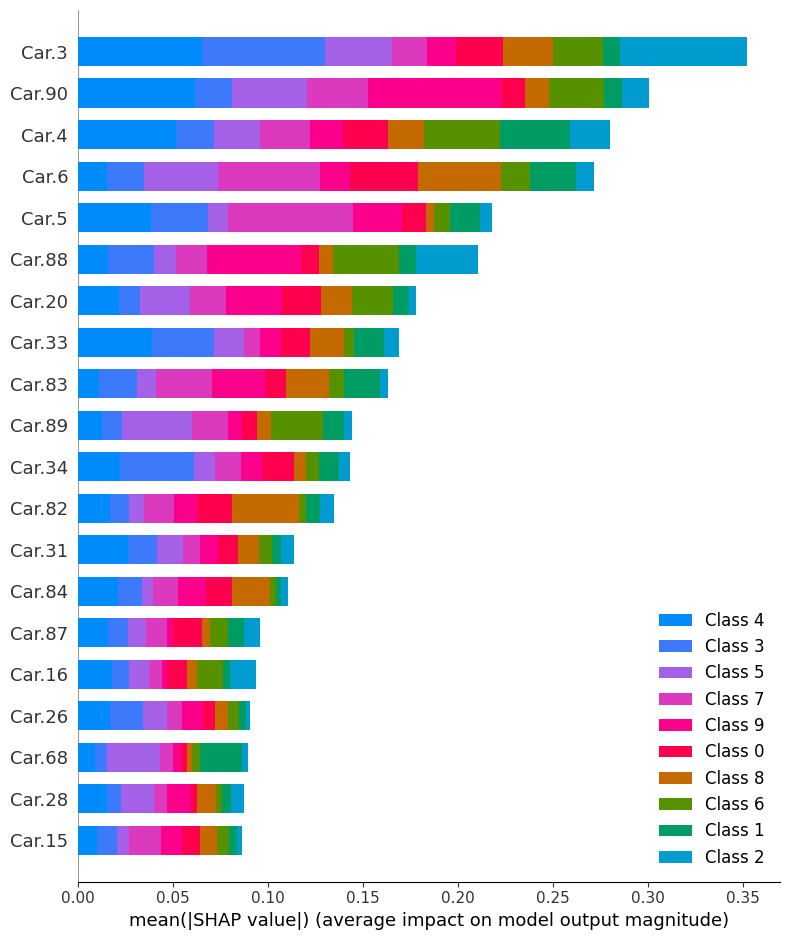

In [13]:
import shap

# Crear un explainer basado en el modelo entrenado
explainer = shap.Explainer(model, X_train)

# Obtener valores SHAP para las primeras 100 muestras (puedes aumentar)
shap_values = explainer(X_test[:100])

# Visualizar importancia de características
shap.summary_plot(shap_values, X_test[:100], feature_names=df_filtrado_filas2.drop(columns=['usuario_num', 'muestra', 'sesion', 'digito']).columns)
